In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn import linear_model as lm
from scipy.optimize import nnls, lsq_linear

# part 0: setup

In [2]:
plt.rcParams['figure.figsize'] = (8, 6)

In [3]:
def rsquare(y, yhat):
    residuals = np.linalg.norm(y - yhat, axis=1)
    r2 = 1 - residuals**2 / np.linalg.norm(y - y.mean())**2
    return r2

In [4]:
def plot_path(alphas, coefs, rsquare, title):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].plot(alphas, coefs)
    ax[0].set_xscale('log')
    ax[0].set_ylabel('weights')
    ax[0].set_title(title)
    ax[1].plot(alphas, rsquare)
    ax[1].set_ylabel('$R^2$')
    ax[1].set_xlabel(r'$\alpha$')
    ax[1].set_title('$R^2$')

In [5]:
# reproducible results
np.random.seed(0)

n, p = 18, 10
X = np.random.normal(size=(n, p))
y = np.random.normal(size=n)

# alphas to be used the paths
n_alphas = 200
alphas = np.logspace(-7, 0, n_alphas)

# part 1: standard Ridge

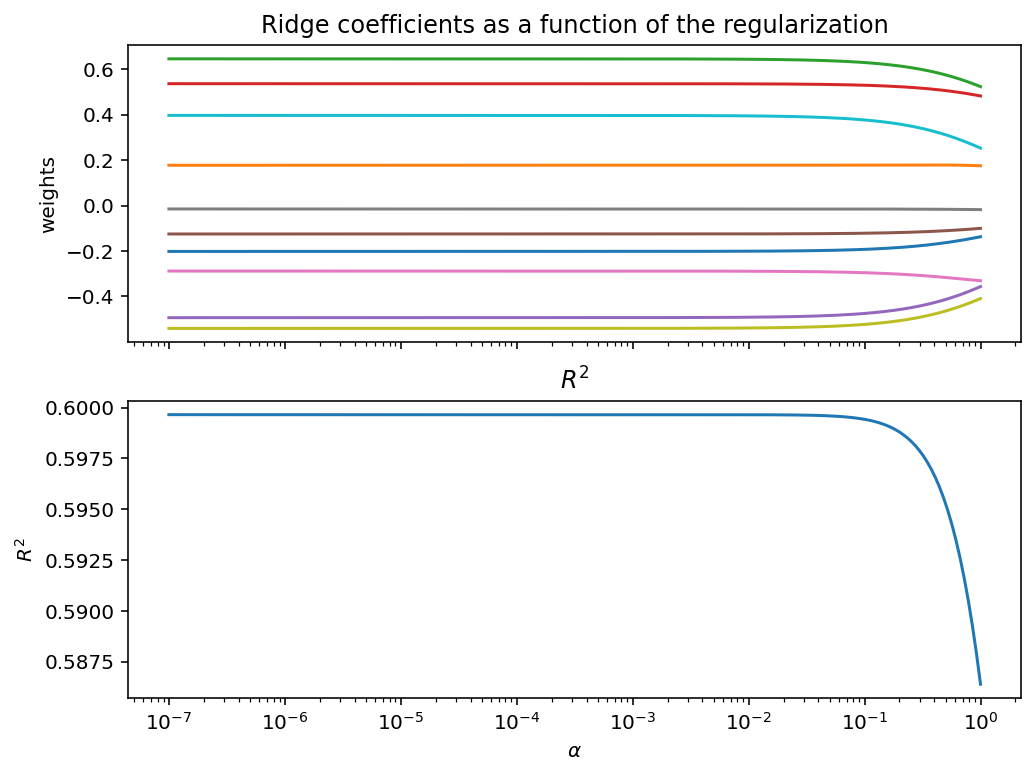

In [6]:
coefs = []
residuals = []
for a in alphas:
    ridge = lm.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    residuals.append(ridge.score(X, y))

plot_path(alphas, coefs, residuals, 'Ridge coefficients as a function of the regularization')

# part 2: Ridge, using ElasticNet

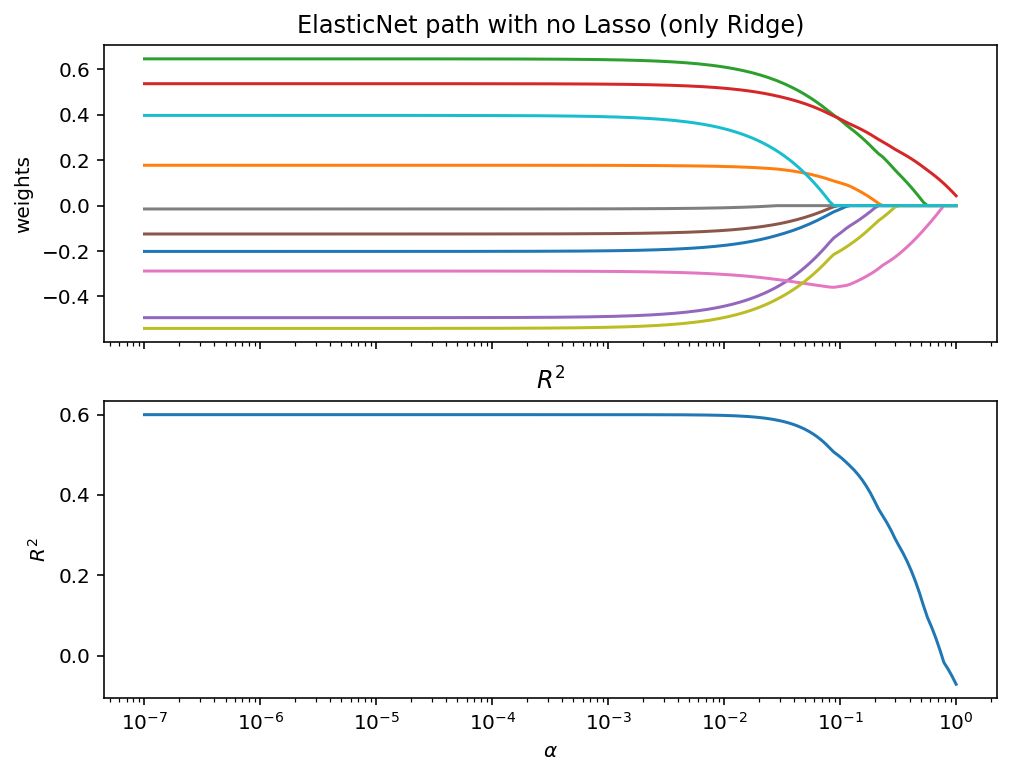

In [7]:
eln = lm.ElasticNet(l1_ratio=0, fit_intercept=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # in this case ElasticNet fails to converge for large alphas
    act_alphas, coefs, dual_gaps = eln.path(X, y, alphas=alphas)

yhat = (X @ coefs).T
r2 = rsquare(y, yhat)
plot_path(act_alphas, coefs.T, r2, 'ElasticNet path with no Lasso (only Ridge)')

# part 3: Non-Negative Ridge, using ElasticNet

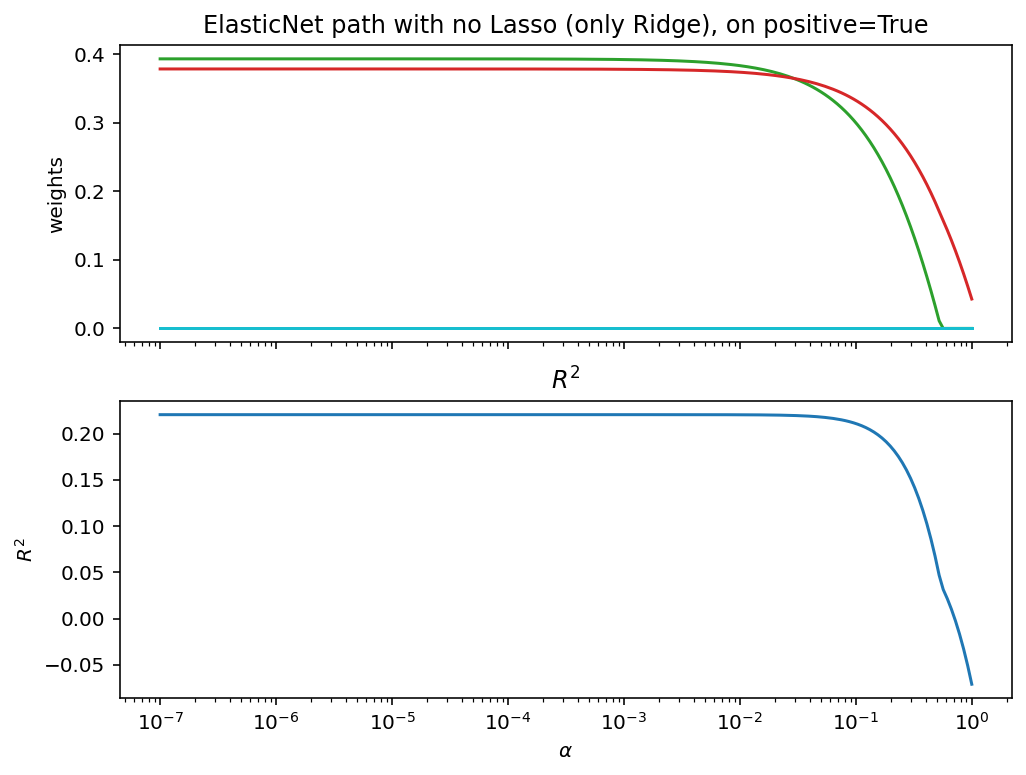

In [8]:
eln = lm.ElasticNet(l1_ratio=0, fit_intercept=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # in this case ElasticNet fails to converge for large alphas
    act_alphas, coefs, dual_gaps = eln.path(X, y, alphas=alphas, positive=True)

yhat = (X @ coefs).T
r2 = rsquare(y, yhat)
plot_path(act_alphas, coefs.T, r2, 'ElasticNet path with no Lasso (only Ridge), on positive=True')

# part 4: Ridge via OLS

In [9]:
def ols_ridge(alpha, X, y, bounds=(-np.inf, np.inf)):
    """return Ridge coefficients by simple OLS"""
    A = X.T @ X + alpha * np.eye(X.shape[1])
    b = X.T @ y
    res = lsq_linear(A, b, bounds=bounds)
    return res.x

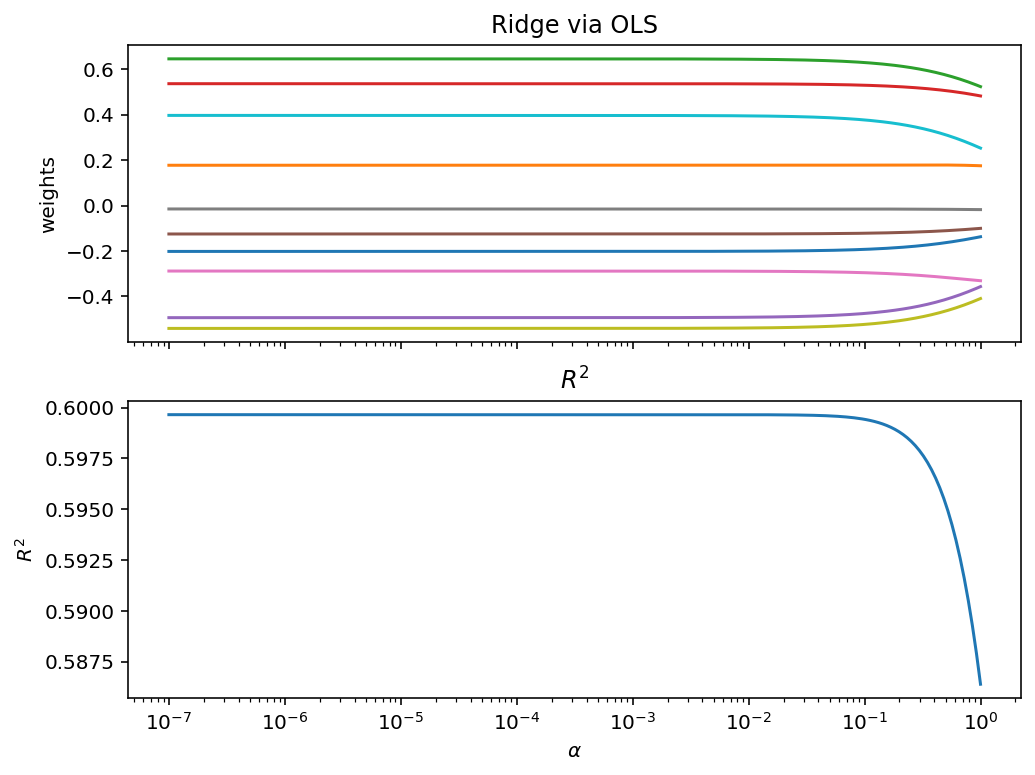

In [10]:
coefs = []
residuals = []
for a in alphas:
    c = ols_ridge(alpha=a, X=X, y=y)
    coefs.append(c)
coefs = np.vstack(coefs).T
yhat = (X @ coefs).T
r2 = rsquare(y, yhat)
plot_path(alphas, coefs.T, r2, 'Ridge via OLS')

# part 5: Non-Negative Ridge, using NNLS

In [11]:
# note: could also use ols_ridge(..., bounds=(0, np.inf))

def nn_ridge(alpha, X, y):
    """return non-negative Ridge coefficients"""
    A = X.T @ X + alpha * np.eye(X.shape[1])
    b = X.T @ y
    coefs, residual = nnls(A, b)
    return coefs, residual

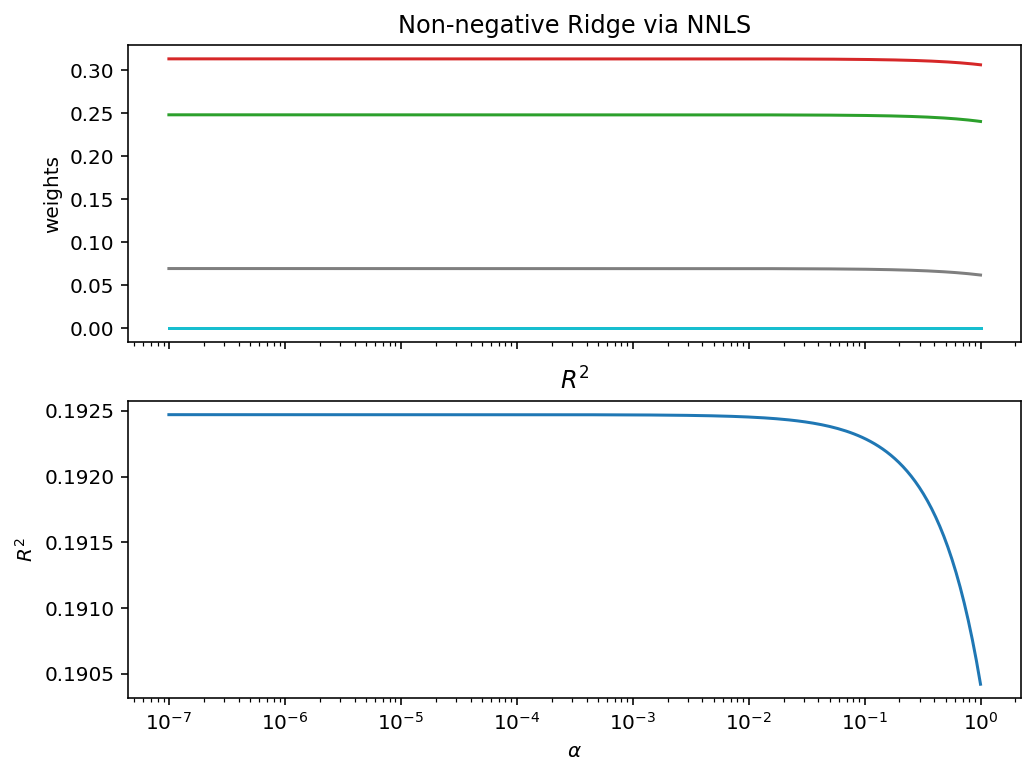

In [12]:
coefs = []
residuals = []
for a in alphas:
    c, res = nn_ridge(alpha=a, X=X, y=y)
    coefs.append(c)
    residuals.append(res)
coefs = np.vstack(coefs).T
yhat = (X @ coefs).T
r2 = rsquare(y, yhat)
plot_path(alphas, coefs.T, r2, 'Non-negative Ridge via NNLS')